# Librerias

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
import locale
import calendar
import math
locale.setlocale(locale.LC_TIME, 'es_ES')

'es_ES'

# Lectura de datos

In [2]:
# Cargar el archivo .nc utilizando xarray
data_boyaca = xr.open_dataset('../data/data_boyaca_final.nc')
df_boyaca = data_boyaca.to_dataframe().reset_index(drop=True)

# Leer el shapefile con los municipios de Boyacá
gdf_boyaca = gpd.read_file('../shapes/MGN_MPIO_POLITICO.shp')
# Seleccionar solo BOYACÁ
gdf_boyaca = gdf_boyaca[gdf_boyaca['DPTO_CNMBR'] == 'BOYACÁ']
# Dejar solo las columnas geometry y MPIO_CNMBR
gdf_boyaca = gdf_boyaca[['geometry', 'MPIO_CNMBR']]
# Renoimbrar la columna MPIO_CNMBR a municipio
gdf_boyaca.rename(columns={'MPIO_CNMBR': 'municipality'}, inplace=True)
# Capitalizar los nombres de los municipios
gdf_boyaca['municipality'] = gdf_boyaca['municipality'].str.title()
df_boyaca['municipality'] = df_boyaca['municipality'].str.title()

In [3]:
df_boyaca['time'] = pd.to_datetime(df_boyaca['time'])
df_boyaca['year'] = df_boyaca['time'].dt.year.astype(str)
df_boyaca['month'] = df_boyaca['time'].dt.month.apply(lambda x: calendar.month_name[x]).str.capitalize()

In [4]:
# Esto es para hacer el merge con el shapefile
# mun_df_boyaca = df_boyaca['municipality'].unique()
# mun_df_boyaca.sort()
# mun_gf_boyaca = gdf_boyaca['municipality'].unique()
# mun_gf_boyaca.sort()
# # mostrar los elementos diferentes entre los dos arreglos
# diferents_df = np.setdiff1d(mun_df_boyaca, mun_gf_boyaca)
# diferents_gdf = np.setdiff1d(mun_gf_boyaca, mun_df_boyaca)
# df_boyaca['municipality'].replace(diferents_df, diferents_gdf, inplace=True)
# # merge entre df_boyaca y df_shapefile_boyaca por municipality
# df_boyaca = pd.merge(df_boyaca, gdf_boyaca, on='municipality', how='left')

Las precipitaciones se clasifican según su intensidad:
- Moderadas: 2 a 15 mm/h.
- Fuertes: 15 a 30 mm/h.
- Muy fuertes: 30 a 60 mm/h.
- Torrenciales: más de 60 mm/h.

# Diagrama de cajas y bigotes para la precipitación de cada coordenada de medicion en cada municipio por mes

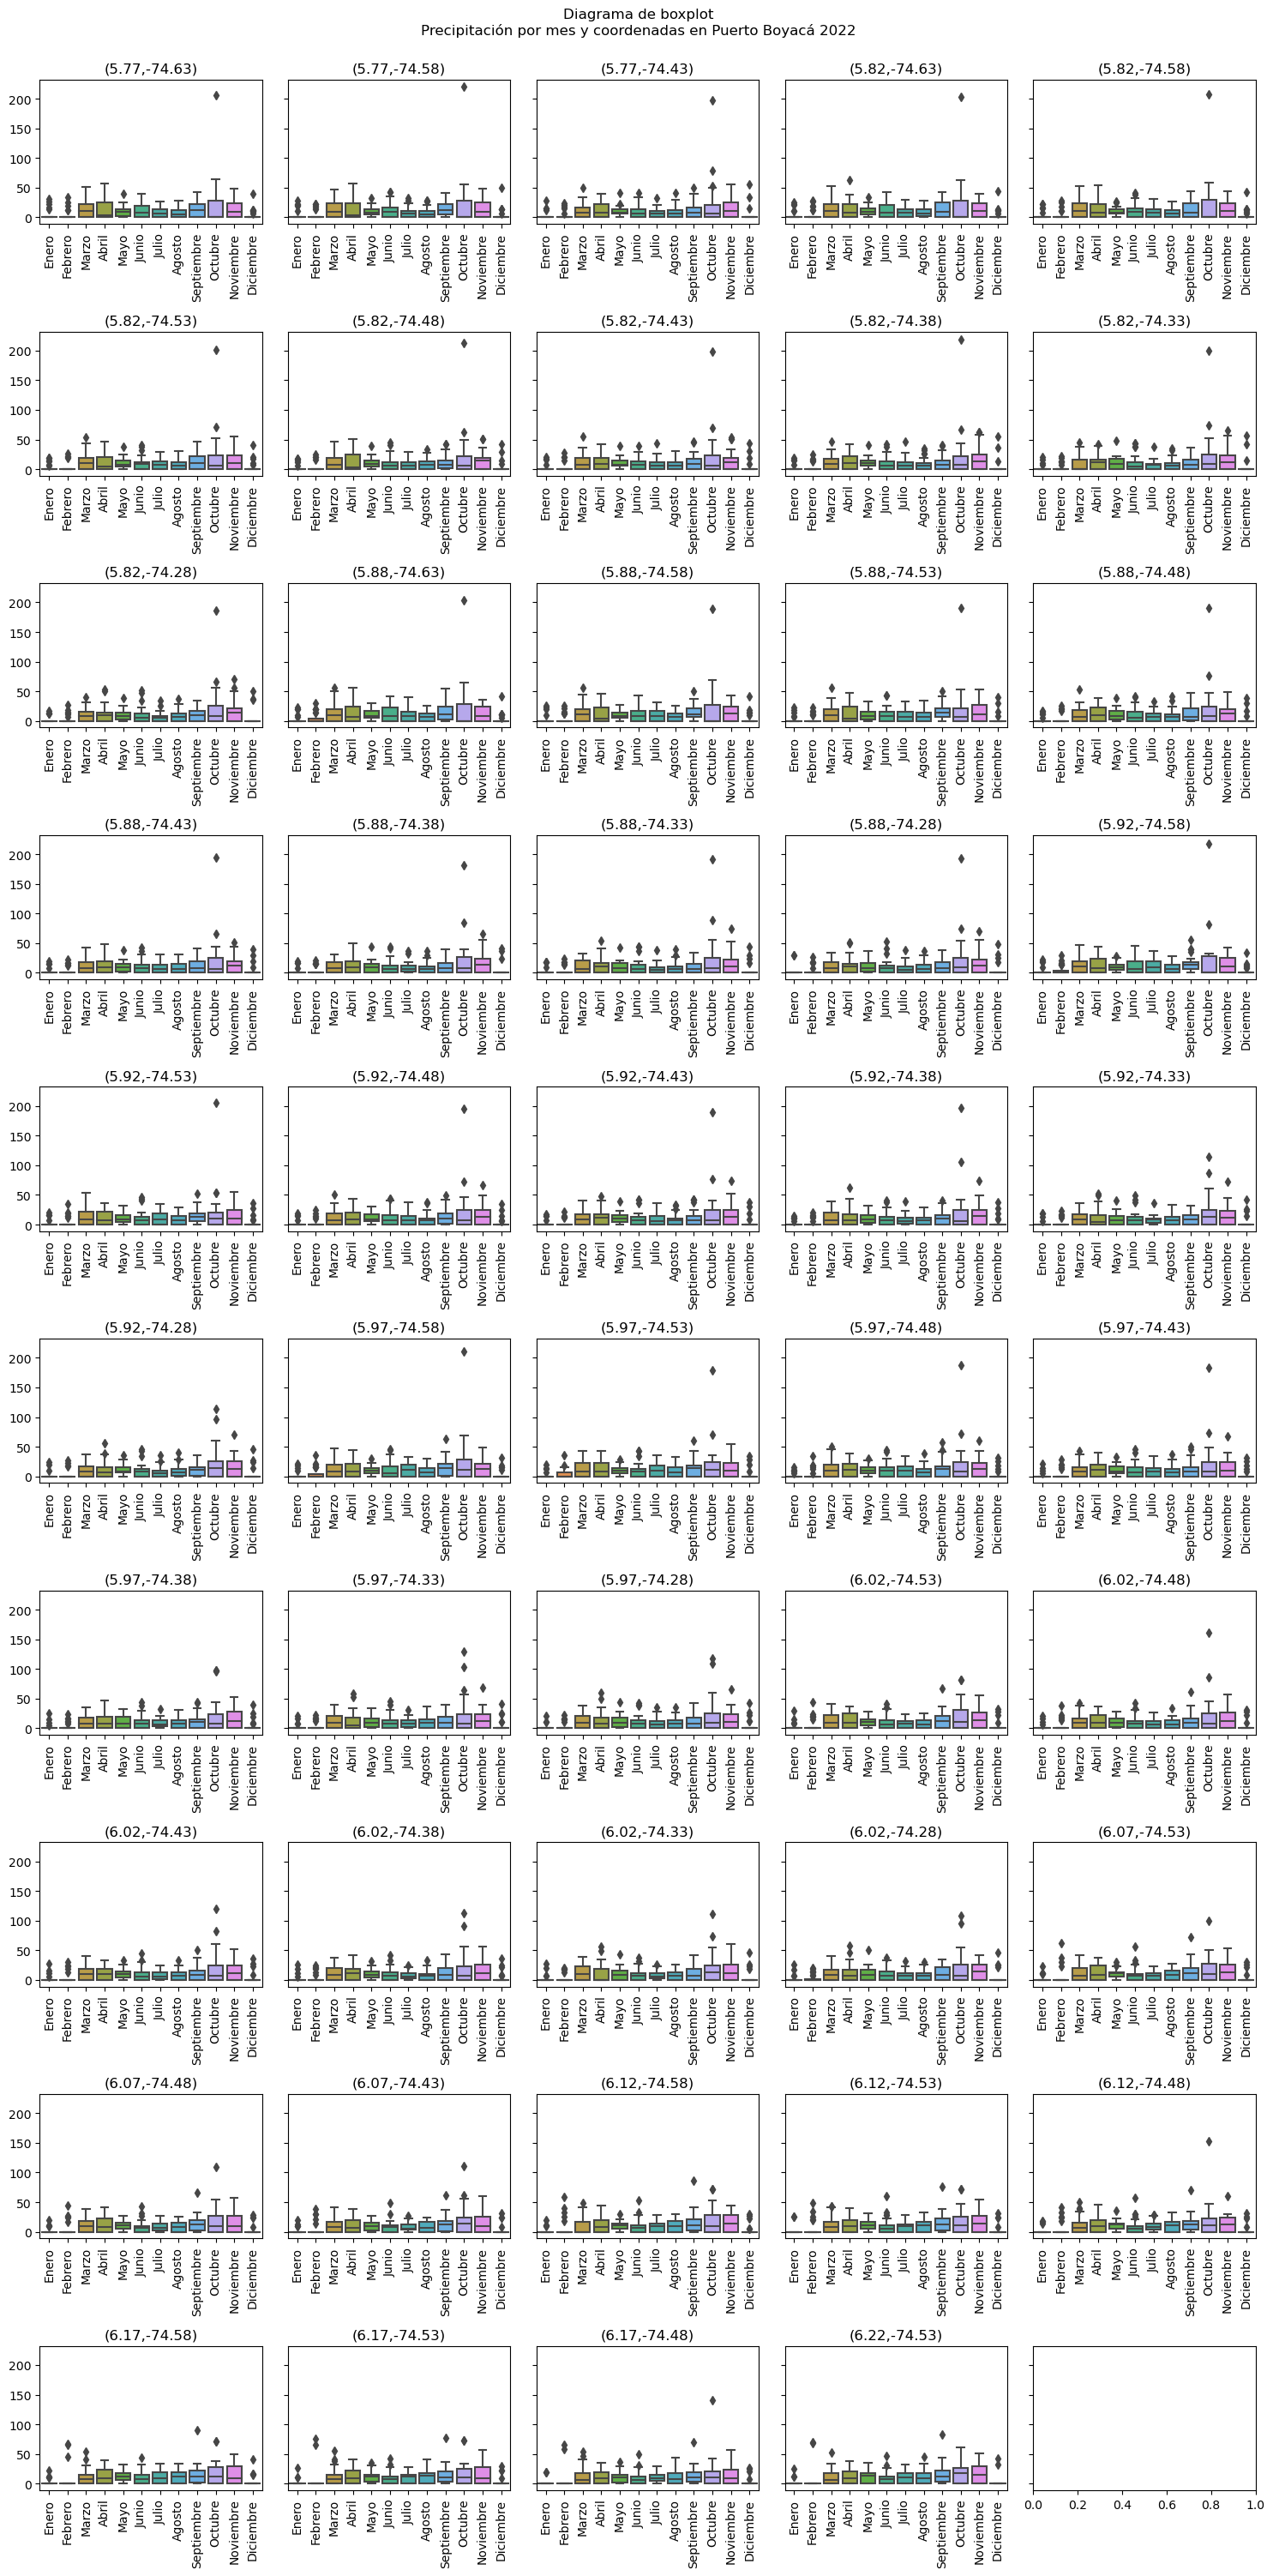

In [5]:
year = "2022"
municipality = "Puerto Boyacá"
df_filtered = df_boyaca[df_boyaca['year'] == year]

df_filtered = df_filtered[df_filtered['municipality'] == municipality]
df_filtered['month'] = pd.Categorical(df_filtered['month'], categories=[month.capitalize() for month in list(calendar.month_name)[1:]], ordered=True)

num_points = len(df_filtered.groupby(['latitude','longitude']))

# El numero máximo de columnas va a ser 5
num_cols = 5 if num_points > 5 else num_points
# El número de filas va a ser el número de puntos entre el número de columnas
num_rows = math.ceil(num_points / num_cols)

# Crear la figura y los ejes
fig, ax = plt.subplots(num_rows, num_cols, figsize=(15,3*num_rows), sharey=True)

for i, (lat, lon) in enumerate(df_filtered.groupby(['latitude','longitude']).groups.keys()):
    index_ax = i // num_cols, i % num_cols
    if num_rows == 1:
        index_ax = i

    sns.boxplot(x='month', y='precip', data=df_filtered[(df_filtered['latitude'] == lat) & (df_filtered['longitude'] == lon)], ax=ax[index_ax])
    ax[index_ax].set_title(f'({lat:.2f},{lon:.2f})')
    ax[index_ax].set_ylabel('')
    ax[index_ax].set_xticklabels(ax[index_ax].get_xticklabels(), rotation=90)
    ax[index_ax].set_xlabel('')
        
# Agregar el título
fig.suptitle(f'Diagrama de boxplot\nPrecipitación por mes y coordenadas en {municipality} {year}', y=1)
plt.tight_layout()
plt.show()

# Distancia entre coordenadas

In [6]:
def calculate_distance(lat1, lon1, lat2, lon2):
    # Radio promedio de la Tierra en kilómetros
    R = 6371.0

    # Convertir las coordenadas a radianes
    lat1_rad = math.radians(lat1)
    lon1_rad = math.radians(lon1)
    lat2_rad = math.radians(lat2)
    lon2_rad = math.radians(lon2)

    # Diferencias de latitud y longitud
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad

    # Fórmula de Haversine
    a = math.sin(dlat / 2) ** 2 + math.cos(lat1_rad) * math.cos(lat2_rad) * math.sin(dlon / 2) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distancia = R * c

    return distancia

# Coordenadas de ejemplo
# -73.0250015258789 5.724998474121094
# -72.97500610351562 5.724998474121094
# -73.0250015258789 5.724998474121094
# -72.97500610351562 5.724998474121094
# -73.0250015258789 5.774997711181641
lat1 = 5.724998474121094
lon1 = -73.0250015258789
lat2 = 5.724998474121094
lon2 = -72.97500610351562

# Calcular distancia
distance_km = calculate_distance(lat1, lon1, lat2, lon2)

print("Distancia:", distance_km, "kilómetros")

Distancia: 5.53150863126391 kilómetros


# Mapa de Boyacá con los nombres de los municipios

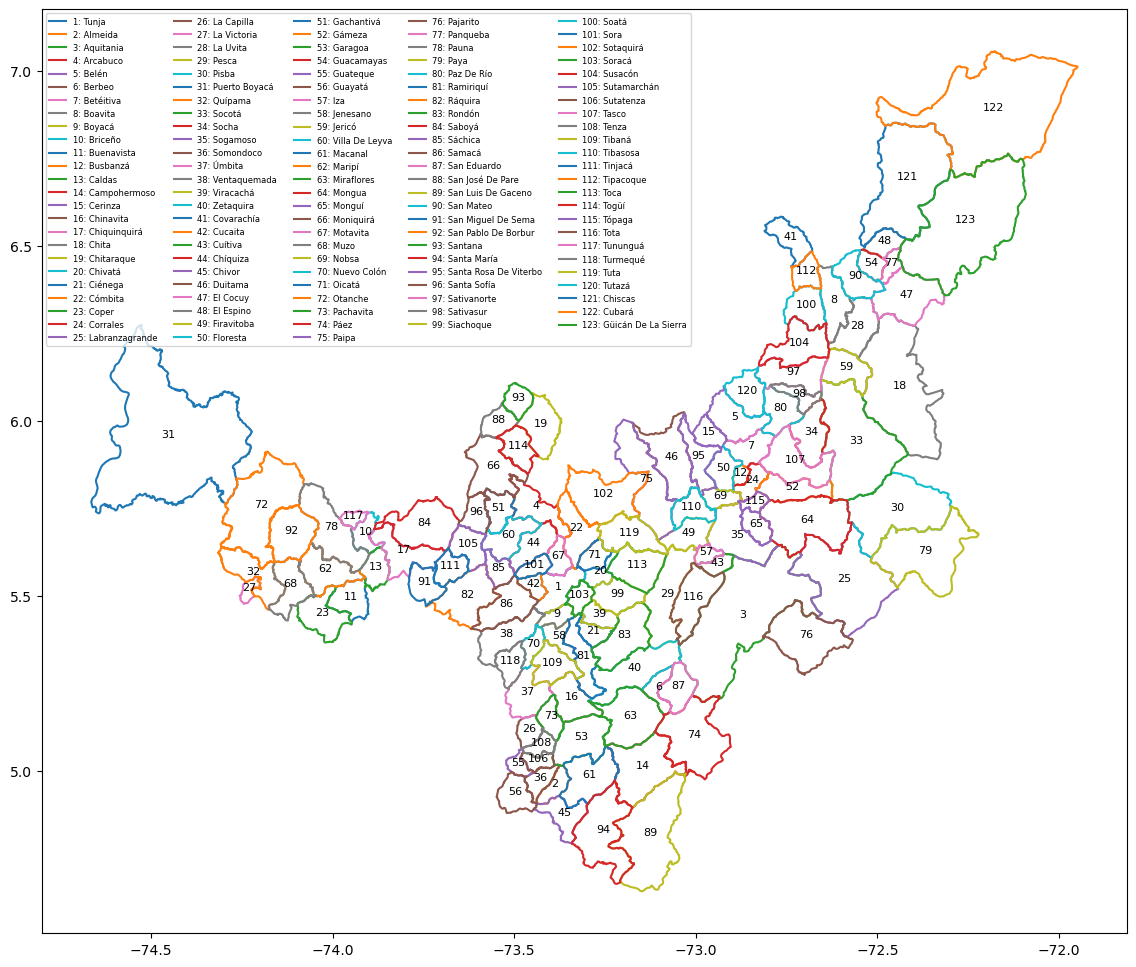

In [7]:
# Crear una figura y un eje
fig, ax = plt.subplots(figsize=(14, 12))

for i, polygon in enumerate(gdf_boyaca.geometry):
    x, y = polygon.exterior.xy
    ax.plot(x, y)
    centroid = polygon.centroid
    ax.annotate(str(i+1), (centroid.x, centroid.y), textcoords="offset points", xytext=(0,0), ha='center', fontsize=8)

# Etiquetas de leyenda
etiquetas_leyenda = [f"{i+1}: {gdf_boyaca.iloc[i]['municipality']}" for i in range(len(gdf_boyaca))]

# Agregar la leyenda al gráfico
ax.legend(labels=etiquetas_leyenda, fontsize=6, ncol=5, loc='upper left')

# Mostrar el gráfico
plt.show()


# Pruebas para los puntos de medición por municipio

In [8]:
year = "2022"
month = "Febrero"

# Filtrar los datos por año y mes y agrupar por latitud, longitud y municipio
df_filtered = df_boyaca[(df_boyaca["year"] == year)]
df_filtered = df_filtered[(df_filtered["month"] == month)]
df_filtered = df_filtered.groupby(["latitude", "longitude", "municipality"]).sum(numeric_only=True).reset_index()


## Grafico de los puntos de medición por municipio

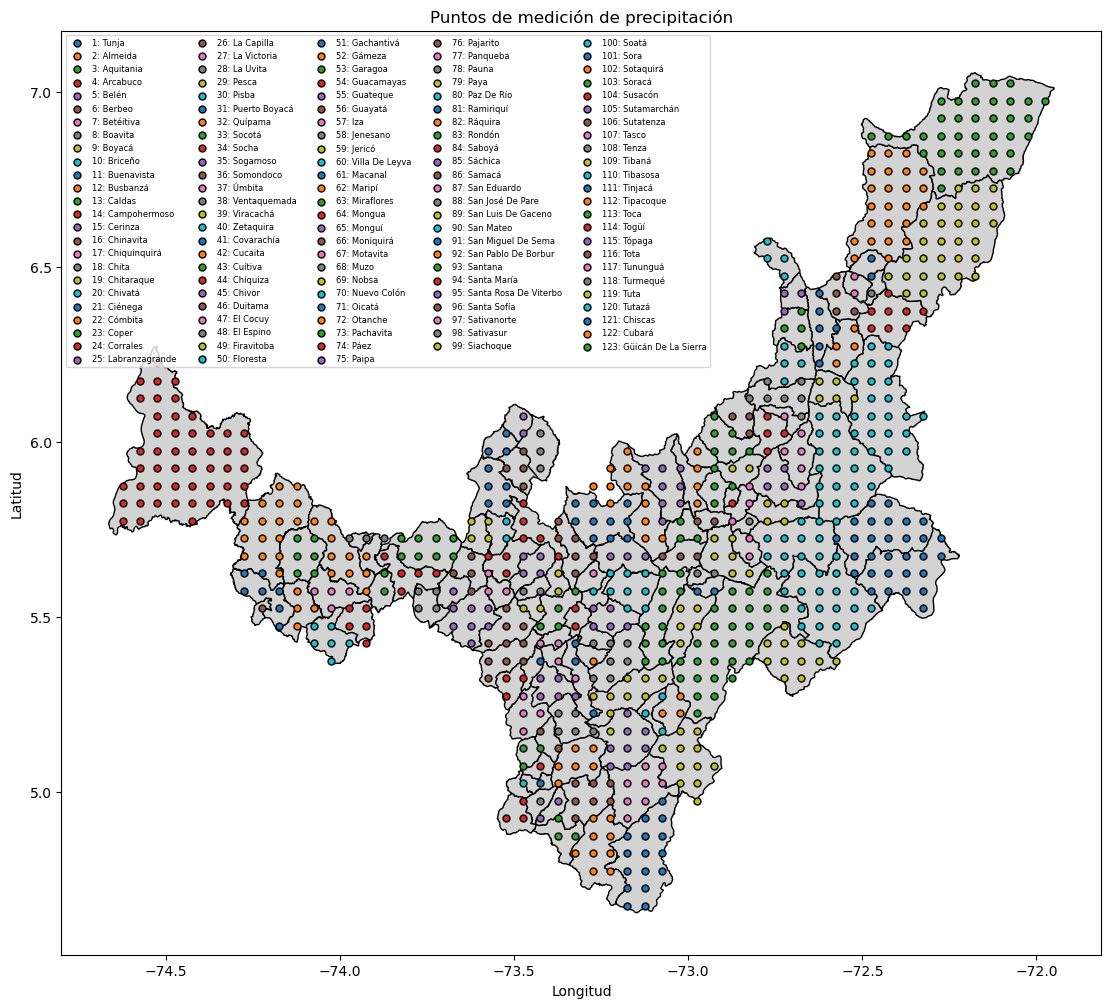

In [9]:
import matplotlib.pyplot as plt

# Crear una figura y ejes
fig, ax = plt.subplots(figsize=(17, 12))

# Graficar el polígono del municipio
gdf_boyaca.plot(ax=ax, color="lightgray", edgecolor="black")


# Graficar las coordenadas para cada municipio con colores diferentes
for i, municipality in enumerate(df_filtered["municipality"].unique()):
    df_municipality = df_filtered[df_filtered["municipality"] == municipality]
    ax.scatter(df_municipality["longitude"], df_municipality["latitude"], s=25, label=municipality, edgecolors="black")

# Configurar el título y los ejes
ax.set_title(f"Puntos de medición de precipitación")
ax.set_xlabel("Longitud")
ax.set_ylabel("Latitud")

# Etiquetas de leyenda
etiquetas_leyenda = [f"{i+1}: {gdf_boyaca.iloc[i]['municipality']}" for i in range(len(gdf_boyaca))]

# Agregar la leyenda al gráfico, situarlo arriba a la izquierda
ax.legend(labels=etiquetas_leyenda, fontsize=6, ncol=5, loc='upper left')

# Mostrar el gráfico
plt.show()


# Grafico de la precipitación total mensual con las celdas de 5.3 km para un año y mes especifico

C:\Users\JimmyZea\AppData\Local\Temp\ipykernel_11480\4087052192.py:35: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  fig.colorbar(cbar, shrink=0.5)


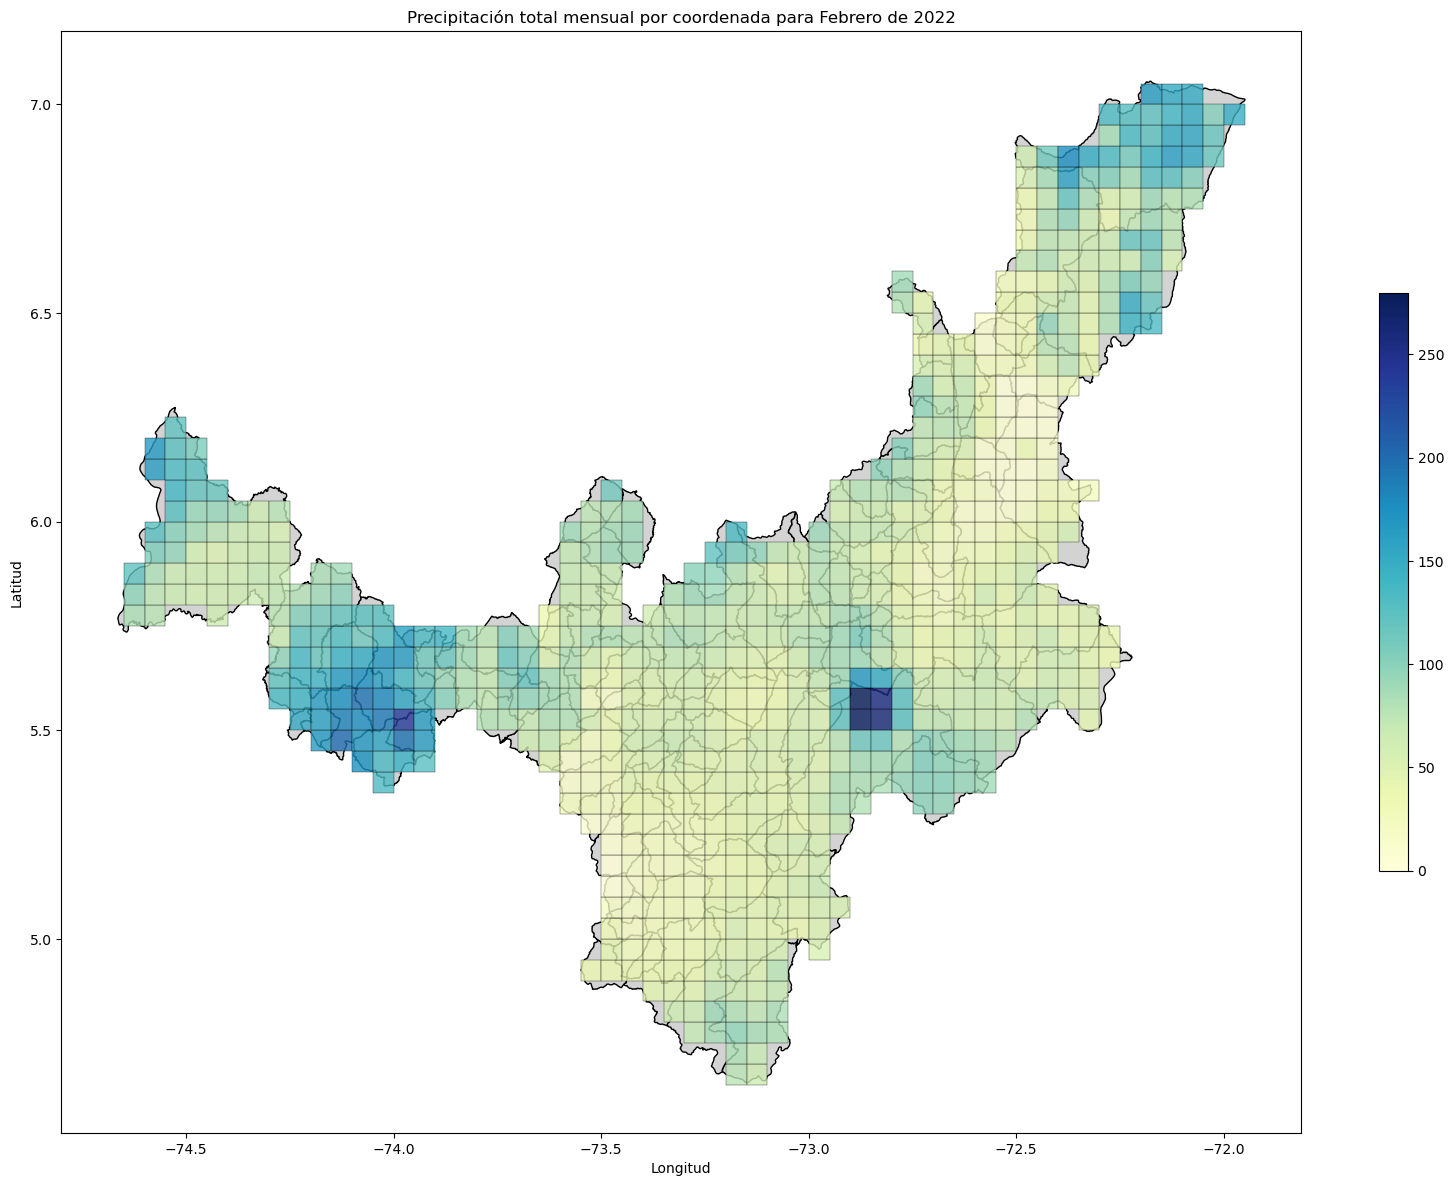

In [10]:
from matplotlib.patches import Rectangle
import matplotlib.colors as mcolors

# Crear una figura y ejes
fig, ax = plt.subplots(figsize=(20, 15))

# Graficar el polígono del municipio
gdf_boyaca.plot(ax=ax, color="lightgray", edgecolor="black")

# Crear una instancia de la escala de colores YlGnBu
cmap = plt.get_cmap("YlGnBu")

# Obtener los valores mínimos y máximos de precipitación para la escala de colores
min_precip = df_filtered["precip"].min()
max_precip = df_filtered["precip"].max()

# Graficar la precipitación mensual utilizando un rectángulo de 0.05 x 0.05 grados
for x, y, precip, lat, lon in zip(df_filtered["longitude"], df_filtered["latitude"], df_filtered["precip"], df_filtered["longitude"], df_filtered["latitude"]):
    # Normalizar el valor de precipitación para que esté en el rango [0, 1]
    normalized_precip = (precip - min_precip) / (max_precip - min_precip)
    
    # Obtener el color correspondiente a la escala YlGnBu para el valor de precipitación
    color = cmap(normalized_precip)
    
    # El valor de 0.05 grados es equivalente a 5.55 km en la latitud y 5.53 km en la longitud de Boyacá (1 grado = 110.6 km)
    # Se usa 0.025 para centrar el rectángulo en la coordenada (x, y)
    rectangle = Rectangle((x - 0.025, y - 0.025), 0.05, 0.05, alpha=0.8, color=color, ec="black", lw=0.3)
    ax.add_patch(rectangle)

# Configurar la escala de colores
norm = mcolors.Normalize(vmin=min_precip, vmax=max_precip)
cbar = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
cbar.set_array(df_filtered["precip"])
cbar.set_clim(0, df_filtered["precip"].max())
fig.colorbar(cbar, shrink=0.5)

# Configurar el título y los ejes
ax.set_title(f"Precipitación total mensual por coordenada para {month} de {year}")
ax.set_xlabel("Longitud")
ax.set_ylabel("Latitud")

# Mostrar el gráfico
plt.show()


## Grafico interactivo con las cekdas de 5.3km

In [ ]:
import plotly.graph_objects as go

# Crear una instancia de la escala de colores YlGnBu
cmap = plt.get_cmap("YlGnBu")

# Obtener los valores mínimos y máximos de precipitación para la escala de colores
min_precip = df_filtered["precip"].min()
max_precip = df_filtered["precip"].max()

# Normalizar el valor de precipitación para que esté en el rango [0, 1]
df_filtered["normalized_precip"] = (df_filtered["precip"] - min_precip) / (max_precip - min_precip)

# Obtener el color correspondiente a la escala YlGnBu para el valor de precipitación
df_filtered["color"] = df_filtered["normalized_precip"].apply(cmap)

# Función para convertir color RGB a hexadecimal
def rgb_to_hex(color):
    return "#{:02x}{:02x}{:02x}".format(int(color[0] * 255), int(color[1] * 255), int(color[2] * 255))

# Convertir colores de RGB a hexadecimal
df_filtered["color"] = df_filtered["color"].apply(rgb_to_hex)

# Crear la figura interactiva con plotly graph objects
fig = go.Figure()

# Agregar los rectángulos en lugar de puntos
for lat, lon, color, precip in zip(df_filtered["latitude"], df_filtered["longitude"], df_filtered["color"], df_filtered["precip"]):
    rectangle = go.Scattermapbox(
        lat=[lat - 0.025, lat - 0.025, lat + 0.025, lat + 0.025, lat - 0.025],
        lon=[lon - 0.025, lon + 0.025, lon + 0.025, lon - 0.025, lon - 0.025],
        fill="toself",
        fillcolor=color,
        line=dict(color="black"),
        mode="lines",
        opacity=0.7,
        hoverinfo="text",
        hovertext=f"Precipitación: {precip}",
    )
    fig.add_trace(rectangle)

# Configurar el diseño del mapa
fig.update_layout(
    mapbox_style="open-street-map",
    mapbox_zoom=6,
    mapbox_center={"lat": df_filtered["latitude"].mean(), "lon": df_filtered["longitude"].mean()},
    title=f"Precipitación mensual en {year}",
)

# Mostrar el gráfico interactivo
fig.show(renderer="notebook")
# Guardar el gráfico interactivo en un archivo HTML
fig.write_html("precipitacion_mensual.html")

In [ ]:
# import plotly.graph_objects as go

# scl = [0,"rgb(150,0,90)"],[0.125,"rgb(0, 0, 200)"],[0.25,"rgb(0, 25, 255)"],\
# [0.375,"rgb(0, 152, 255)"],[0.5,"rgb(44, 255, 150)"],[0.625,"rgb(151, 255, 0)"],\
# [0.75,"rgb(255, 234, 0)"],[0.875,"rgb(255, 111, 0)"],[1,"rgb(255, 0, 0)"]

# fig = go.Figure(data=go.Scattergeo(
#     lat = df_filtered['latitude'],
#     lon = df_filtered['longitude'],
#     text = df_filtered['precip'].astype(str) + ' mm',
#     marker = dict(
#         color = df_filtered['precip'],
#         colorscale = scl,
#         reversescale = True,
#         opacity = 0.7,
#         size = 10,
#         colorbar = dict(
#             titleside = "right",
#             outlinecolor = "rgba(68, 68, 68, 0)",
#             ticks = "outside",
#             showticksuffix = "last",
#             dtick = 0.1
#         )
#     )
# ))

# fig.update_layout(
#     title = 'Precipitación mensual en Boyacá',
#     geo = dict(
#         scope = 'south america',
#         showland = True,
#         landcolor = "rgb(212, 212, 212)",
#         subunitcolor = "rgb(255, 255, 255)",
#         countrycolor = "rgb(255, 255, 255)",
#         showlakes = True,
#         lakecolor = "rgb(255, 255, 255)",
#         showsubunits = True,
#         showcountries = True,
#         resolution = 50,
#         projection = dict(
#             type = 'conic conformal',
#             rotation_lon = -74
#         ),
#         lonaxis = dict(
#             showgrid = True,
#             gridwidth = 0.5,
#             range= [ -75.0, -72.0 ],
#             dtick = 5
#         ),
#         lataxis = dict (
#             showgrid = True,
#             gridwidth = 0.5,
#             range= [ 4.0, 7.0 ],
#             dtick = 5
#         )
#     )
# )

# fig.show(renderer="notebook")

In [ ]:
# import plotly.graph_objects as go

# scl = [0, "rgb(150,0,90)"], [0.125, "rgb(0, 0, 200)"], [0.25, "rgb(0, 25, 255)"], \
#       [0.375, "rgb(0, 152, 255)"], [0.5, "rgb(44, 255, 150)"], [0.625, "rgb(151, 255, 0)"], \
#       [0.75, "rgb(255, 234, 0)"], [0.875, "rgb(255, 111, 0)"], [1, "rgb(255, 0, 0)"]

# fig = go.Figure(data=go.Scattermapbox(
#     lat=df_filtered['latitude'],
#     lon=df_filtered['longitude'],
#     text=df_filtered['precip'].astype(str) + ' mm',
#     marker=dict(
#         color=df_filtered['precip'],
#         colorscale=scl,
#         cmin=df_filtered['precip'].min(),
#         cmax=df_filtered['precip'].max(),
#         colorbar=dict(
#             titleside="right",
#             outlinecolor="rgba(68, 68, 68, 0)",
#             ticks="outside",
#             showticksuffix="last",
#             dtick=0.1
#         ),
#         size=10,
#         symbol='square',  # Use 'square' for filled squares
#         sizemode='area'   # This will make the squares proportional to the 'size' value
#     )
# ))

# fig.update_layout(
#     title='Precipitación mensual en Boyacá',
#     mapbox=dict(
#         style="carto-positron",
#         bearing=0,
#         center=dict(
#             lat=5.5,
#             lon=-73.5
#         ),
#         pitch=0,
#         zoom=7
#     )
# )

# fig.show(renderer="notebook")


## Mapa de calor mensual para las diferentes coordenadas geográficas de un municipio en especifico en un determinado año

In [11]:
year = "2022"
municipality = "Puerto Boyacá"
df_filtered = df_boyaca[df_boyaca['year'] == year]

# Hacer un groupby por latitud, longitud y mes
df_filtered = df_filtered.groupby(['municipality','latitude','longitude', 'month']).sum(numeric_only = True).reset_index()
# Obtener la cantidad de coordenadas por municipio
points_by_municipality = df_filtered.groupby(['latitude', 'longitude', 'municipality']).sum(numeric_only = True).reset_index()['municipality'].value_counts()
# Seleccionar solo un municipio
df_filtered = df_filtered[df_filtered['municipality'] == municipality]
df_filtered['month'] = pd.Categorical(df_filtered['month'], categories=[month.capitalize() for month in list(calendar.month_name)[1:]], ordered=True)

In [16]:
# Cantidad de coordenadas por municipio
points_by_municipality

Puerto Boyacá    49
Cubará           38
Aquitania        29
Güicán           29
Chiscas          24
                 ..
Ciénega           1
Nuevo Colón       1
Guateque          1
Tenza             1
Oicatá            1
Name: municipality, Length: 123, dtype: int64

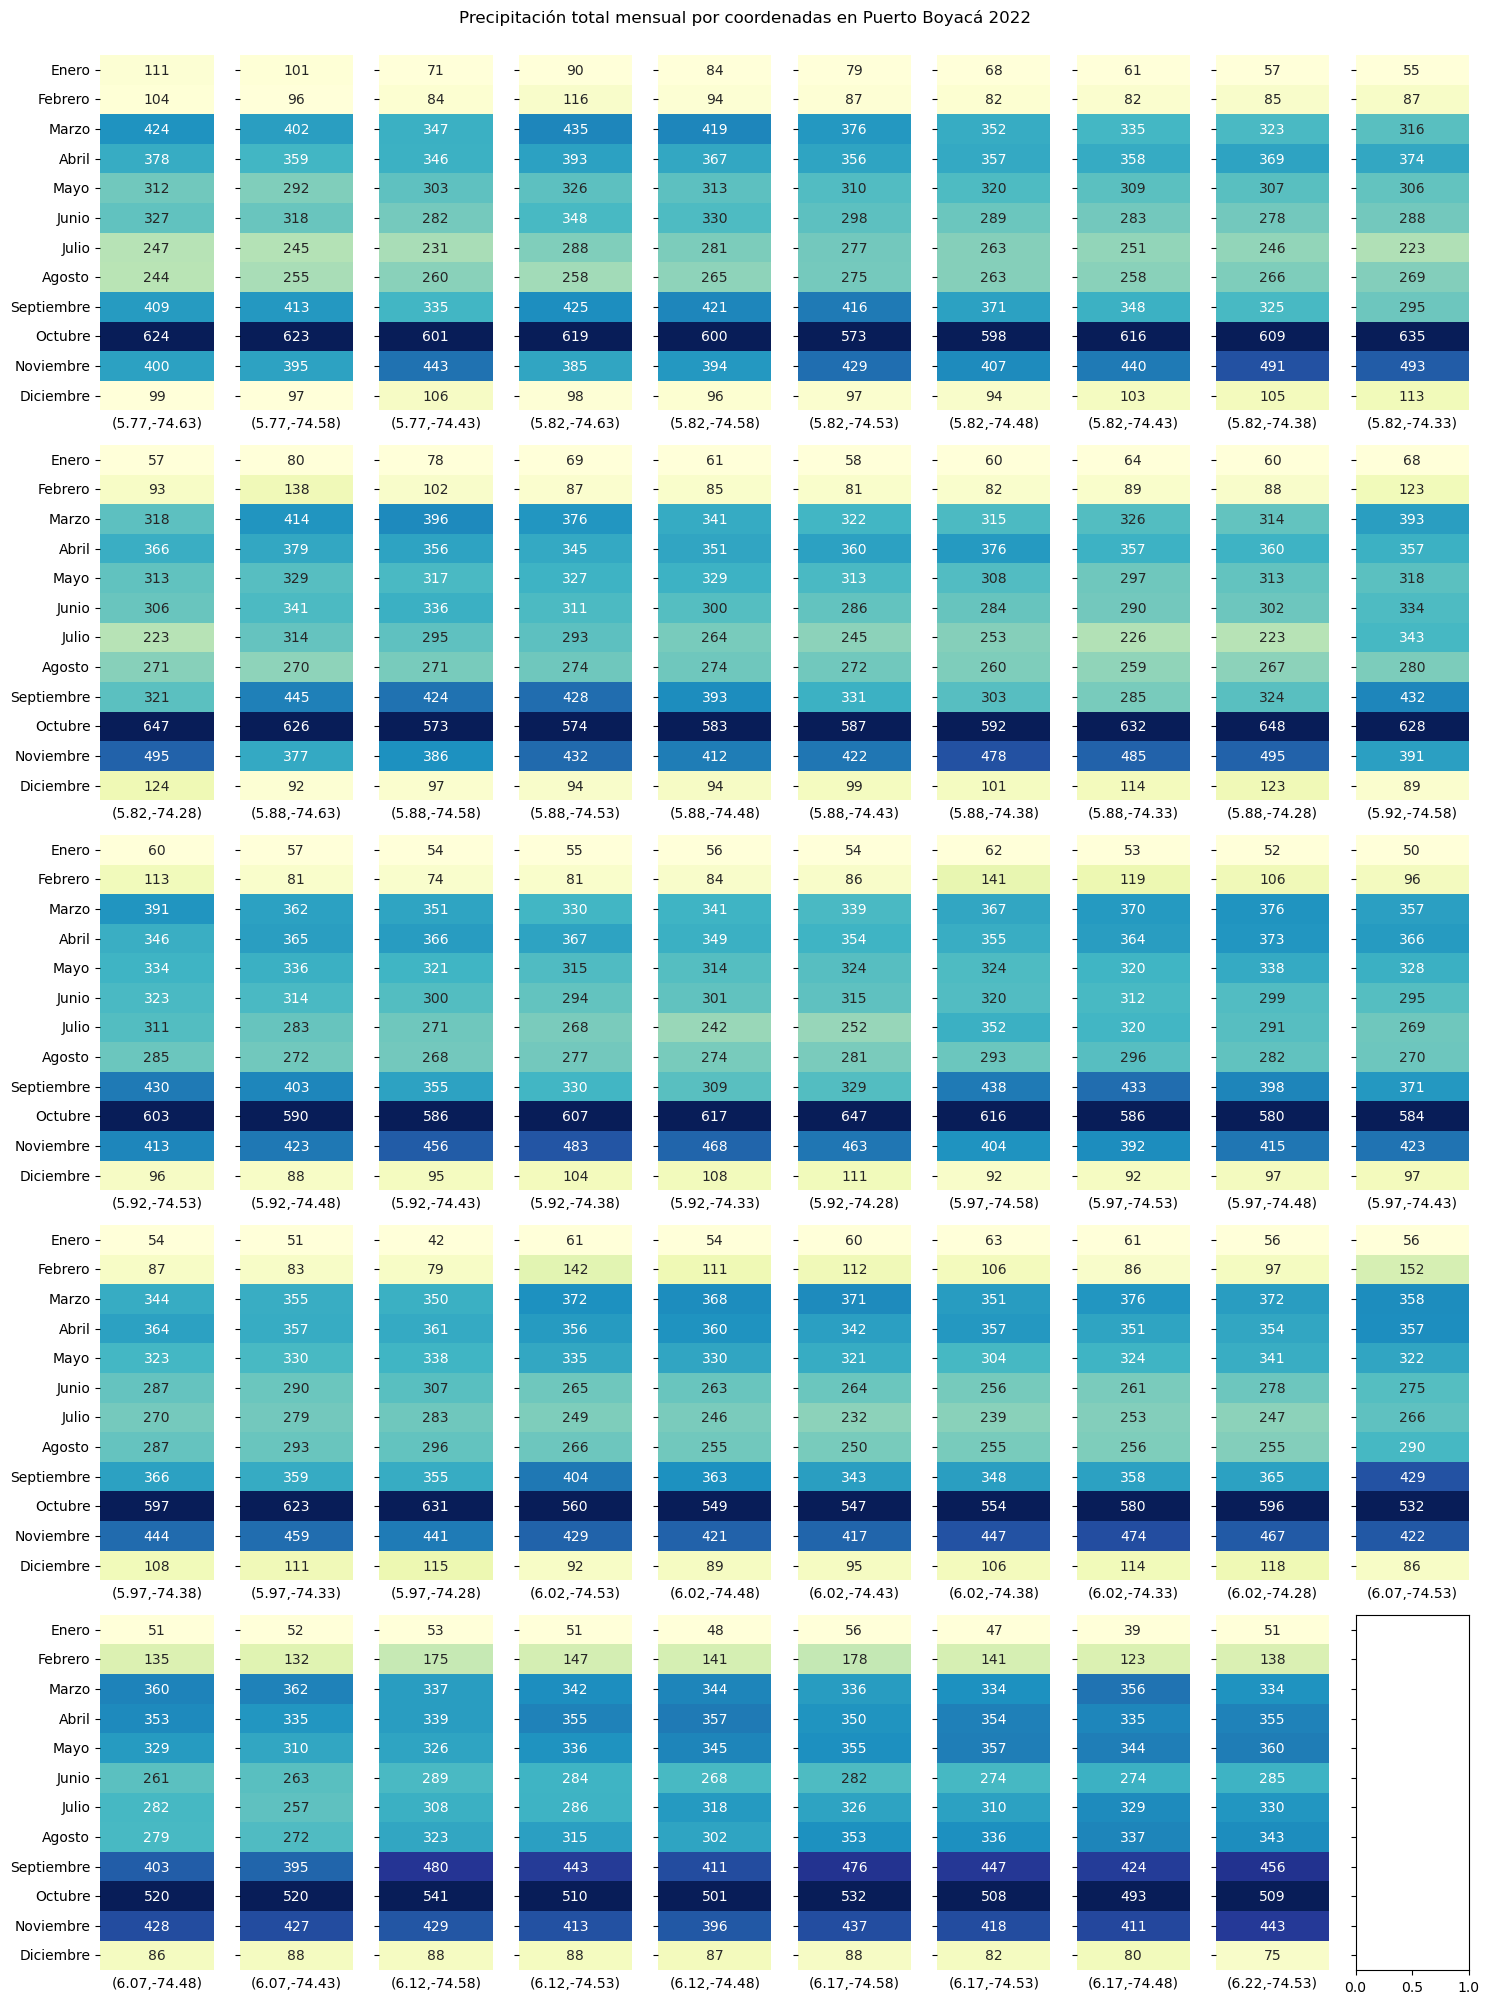

In [12]:
# Mapa de calor opcion 1

num_points = len(df_filtered.groupby(['latitude','longitude']))

# El numero máximo de columnas va a ser 8
num_cols = 10 if num_points > 10 else num_points
# El número de filas va a ser el número de puntos entre el número de columnas
num_rows = math.ceil(num_points / num_cols)

# Crear la figura y los ejes
fig, ax = plt.subplots(num_rows, num_cols, figsize=(15,4*num_rows), sharey=True)

for i, (lat, lon) in enumerate(df_filtered.groupby(['latitude','longitude']).groups.keys()):
    index_ax = i // num_cols, i % num_cols
    if num_rows == 1:
        index_ax = i

    sns.heatmap(df_filtered[(df_filtered['latitude'] == lat) & (df_filtered['longitude'] == lon)].pivot_table(index='month', values='precip'), cmap='YlGnBu', cbar=False, annot=True, fmt=".0f", ax=ax[index_ax])
    ax[index_ax].set_xlabel(f'({lat:.2f},{lon:.2f})')
    ax[index_ax].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    ax[index_ax].set_ylabel('')
        
# Agregar el título
fig.suptitle(f'Precipitación total mensual por coordenadas en {municipality} {year}', y=1)
plt.tight_layout()
plt.show()

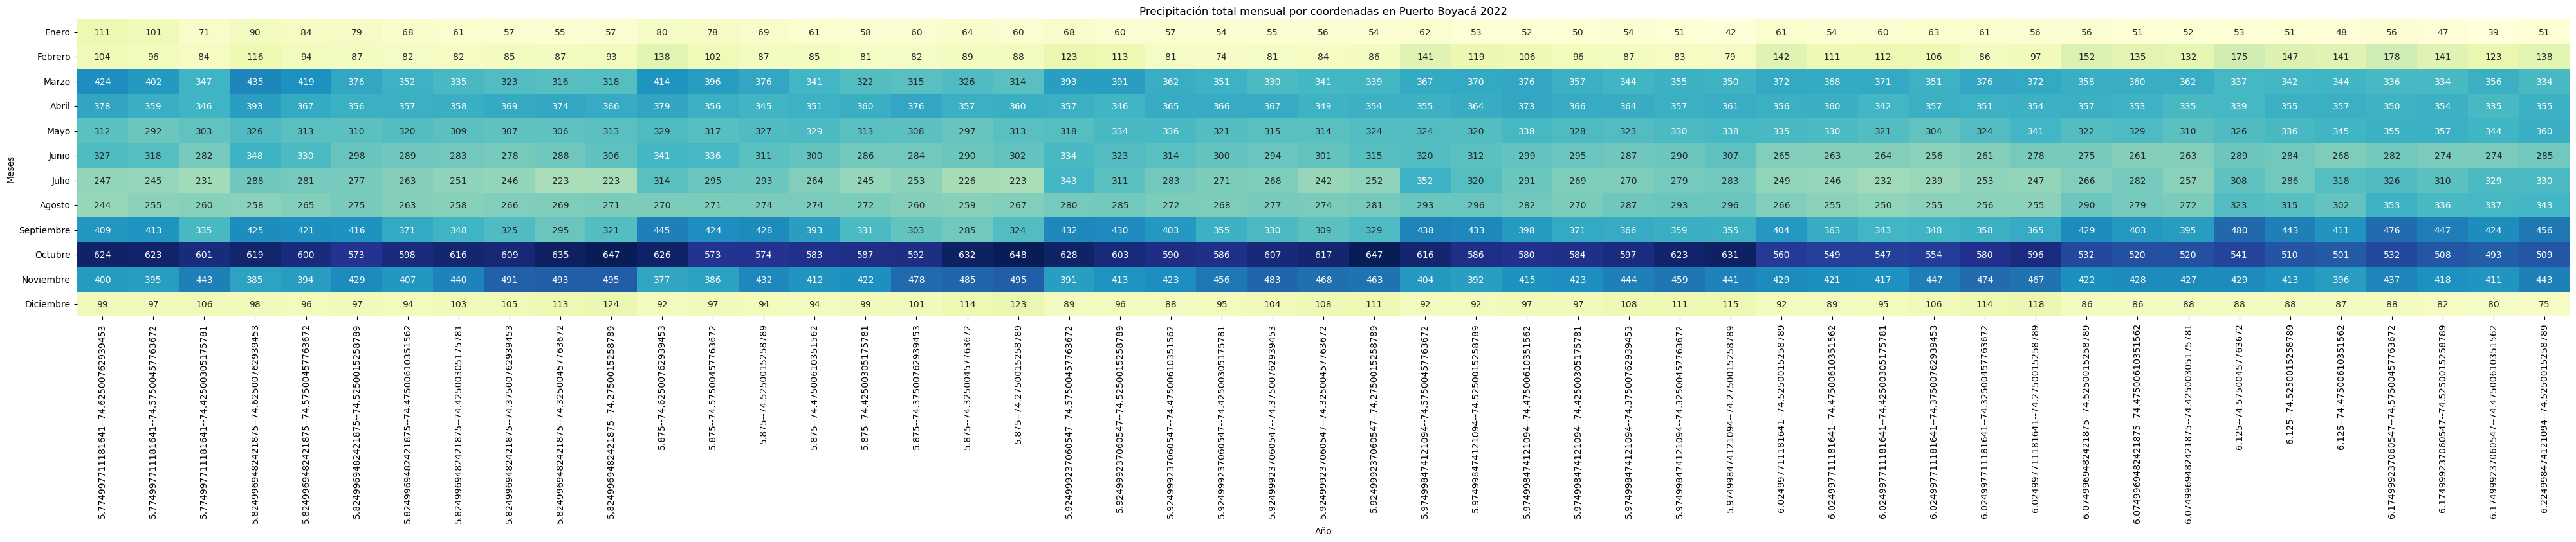

In [13]:
# Mapa de calor opcion 2

# Usar pivot_table para crear un dataframe con los valores de precipitación
df_filtered = df_filtered.pivot_table(index='month', columns=['latitude', 'longitude'], values='precip')

# Crear el mapa de calor
plt.figure(figsize=(50, 6))

sns.heatmap(df_filtered, cmap='YlGnBu', cbar=False, annot=True, fmt=".0f")

# Configurar los ejes y etiquetas
plt.xlabel('Año')
plt.ylabel('Meses')
plt.title(f'Precipitación total mensual por coordenadas en {municipality} {year}')

# Mostrar la figura
plt.show()

# Scatter plot para la precipitacion mensual total de un año en particular por coordenadas geográficas (latitud, longitud)

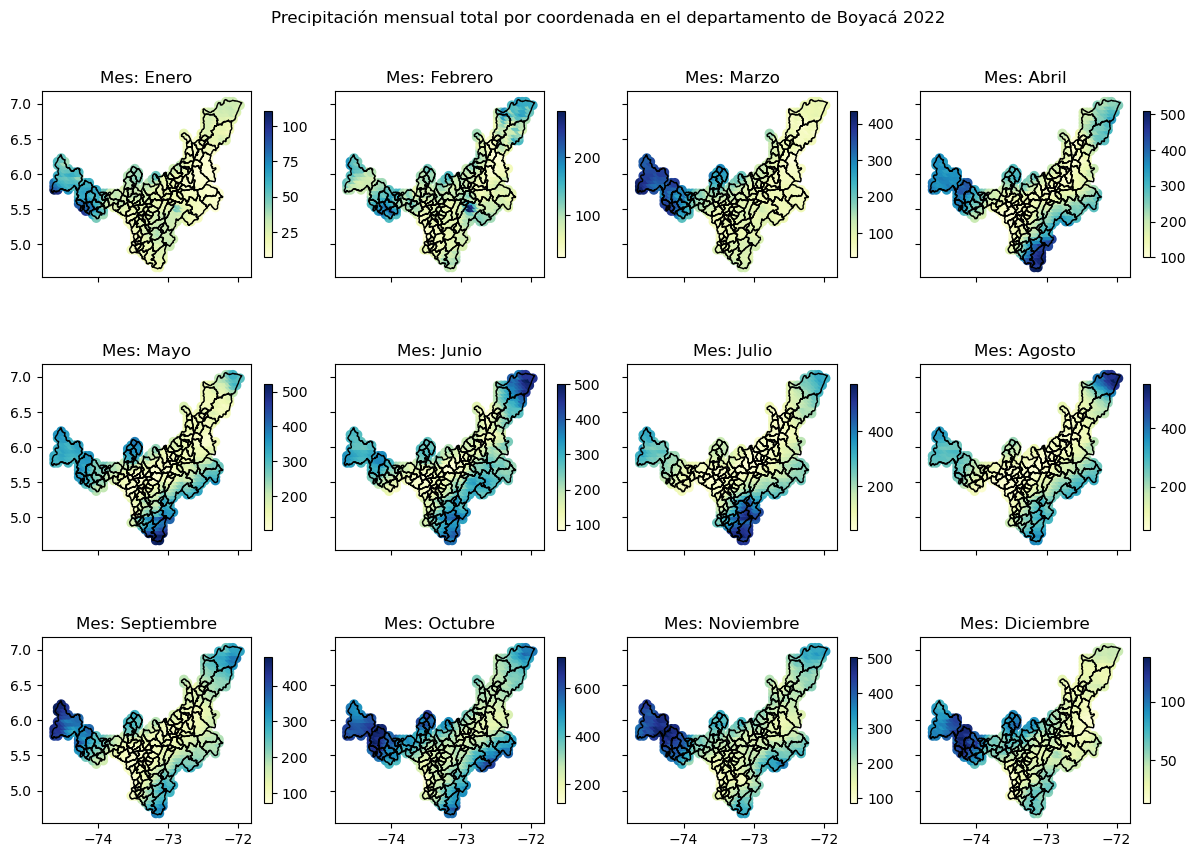

In [19]:
# Filtrar los datos por año específico
year = "2022"
df_filtered = df_boyaca[df_boyaca['year'] == year]

num_months = len(df_filtered['month'].unique())

num_rows = math.ceil(num_months/4)

# Crear la cuadrícula de subtramas
fig, axes = plt.subplots(num_rows, 4, figsize=(12, 9), sharex=True, sharey=True)
 
# Iterar sobre los meses
for month, ax in zip(range(1, 13), axes.flat):
    # Filtrar los datos por mes específico
    pr_month = df_filtered[df_filtered['time'].dt.month == month]

    # Obtener el nombre del mes en español
    month_name = calendar.month_name[month].capitalize()

    # Calcular el promedio de precipitación para cada punto
    precip_avg = pr_month.groupby(['latitude', 'longitude'])['precip'].sum().reset_index()
    if month == 2:
        precip_feb = precip_avg

    # Plot del mapa de calor en la subtrama actual
    im = ax.scatter(precip_avg['longitude'], precip_avg['latitude'], c=precip_avg['precip'], cmap='YlGnBu')
    gdf_boyaca.plot(ax=ax, color='none', edgecolor='k')
    ax.set_title(f'Mes: {month_name}')
    # Agregar una barra de color 
    fig.colorbar(im, ax=ax, shrink=0.5)


fig.suptitle(f'Precipitación mensual total por coordenada en el departamento de Boyacá {year}')
# Ajustar los espacios entre las subtramas
plt.tight_layout()

# Mostrar la figura
plt.show()

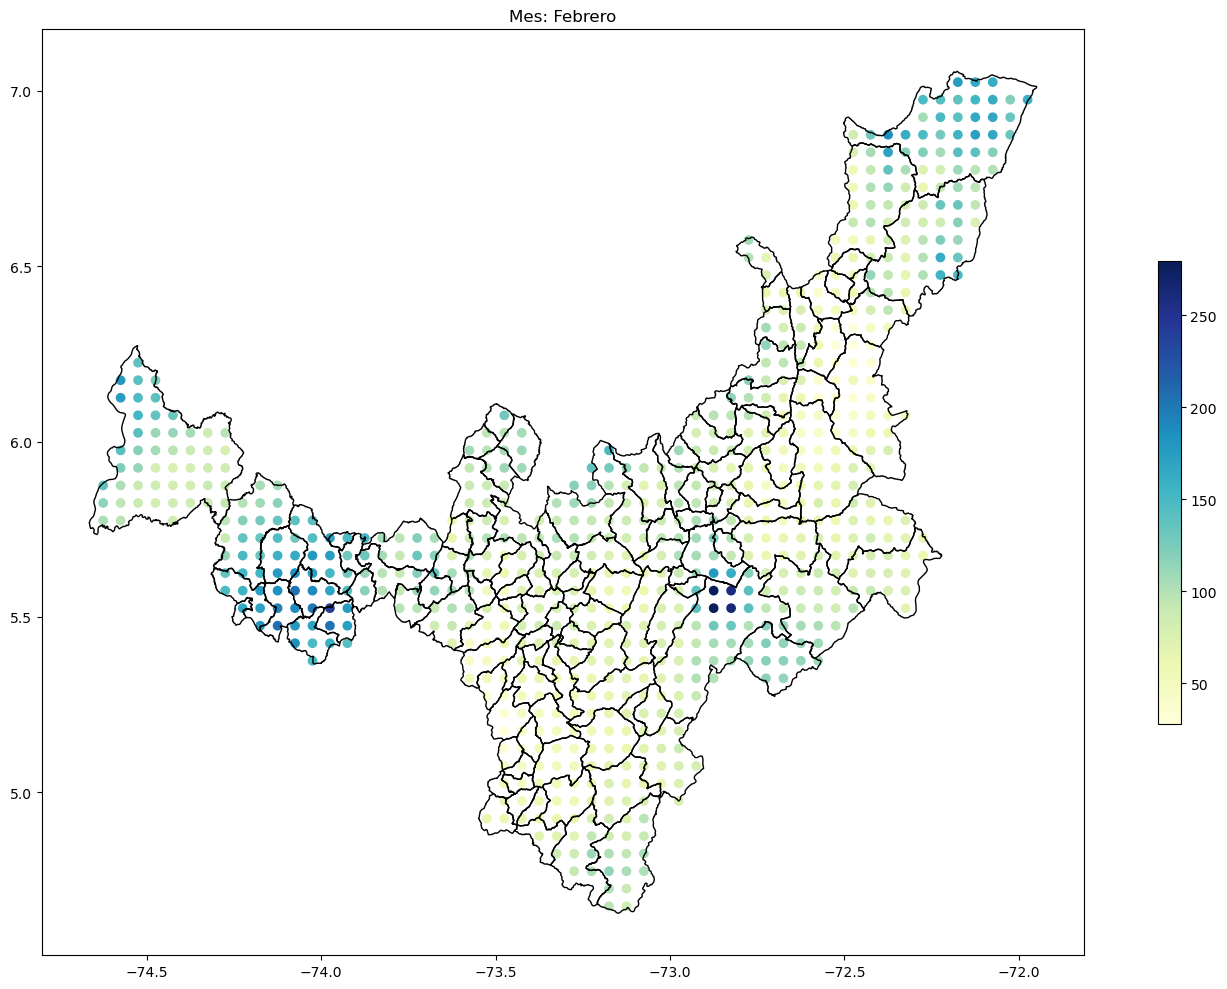

In [22]:
# Para un solo mes

# Filtrar los datos por año específico
pr_year = df_boyaca[df_boyaca['year'] == "2022"]

# Crear la cuadrícula de subtramas
fig, ax = plt.subplots(1, 1, figsize=(15, 10), sharex=True, sharey=True)
 
pr_month = pr_year[pr_year['month'] == 'Febrero']

# Calcular el promedio de precipitación para cada punto
precip_avg = pr_month.groupby(['latitude', 'longitude','municipality'])['precip'].sum().reset_index()

# Plot del mapa de calor en la subtrama actual
im = ax.scatter(precip_avg['longitude'], precip_avg['latitude'], c=precip_avg['precip'], cmap='YlGnBu')
gdf_boyaca.plot(ax=ax, color='none', edgecolor='k')
ax.set_title(f'Mes: {pr_month["month"].unique()[0]}')
# Agregar una barra de color 
fig.colorbar(im, ax=ax, shrink=0.5)

# Ajustar los espacios entre las subtramas
plt.tight_layout()

# Mostrar la figura
plt.show()

In [27]:
import plotly.express as px
year = '2022'
month = 'Febrero'
# Filtrar los datos por año específico
df_filtered = df_boyaca[df_boyaca['year'] == year]

# Filtrar los datos por mes específico (Febrero)
pr_month = df_filtered[df_filtered['month'] == month]

precip_avg = pr_month.groupby(['latitude', 'longitude', 'municipality'])['precip'].sum().reset_index()

fig = px.scatter_mapbox(precip_avg,
                        lat='latitude',
                        lon='longitude',
                        color='precip',
                        size='precip',
                        hover_name='municipality',
                        hover_data=['precip'],
                        mapbox_style='open-street-map',
                        zoom=7,
                        center={"lat": 5.533, "lon": -73.362},  # Centro del mapa ajustado a Boyacá
                        color_continuous_scale='YlGnBu',
                        title=f'Precipitación mensual total por coordenada en el departamento de Boyacá {month} de {year}'
                        )

fig.update_layout(
    margin={"r": 0, "t": 30, "l": 0, "b": 0},
    coloraxis_colorbar=dict(xanchor="left", x=0),
)

fig.update_traces(marker=dict(size=20, sizemode='diameter'))

# Mostrar el gráfico interactivo
fig.show()


1. Gráfico de Análisis de Tendencias:
   - En este gráfico, se muestra la precipitación promedio a lo largo del tiempo en el área de Boyacá.
   - La línea azul representa el promedio de la precipitación en función del tiempo.
   - La línea roja discontinua indica la tendencia de la precipitación a lo largo del tiempo, calculada mediante una regresión lineal.
   - Si la línea roja tiene una pendiente positiva, indica un aumento en la precipitación a medida que pasa el tiempo, mientras que una pendiente negativa indica una disminución en la precipitación.

2. Gráfico de Anomalías y Variabilidad Interanual:
   - Este gráfico muestra las anomalías de precipitación y la variabilidad interanual en el área de Boyacá.
   - Las anomalías de precipitación se calculan restando el promedio anual de la precipitación de cada año individual.
   - El gráfico muestra la media de estas anomalías a lo largo del tiempo.
   - Los valores positivos indican que la precipitación en un año determinado fue superior al promedio anual, mientras que los valores negativos indican una precipitación por debajo del promedio.

3. Gráfico de Estacionalidad de la Precipitación:
   - Este gráfico representa la estacionalidad de la precipitación en el área de Boyacá.
   - Se calcula el promedio mensual de la precipitación.
   - Cada punto en el gráfico de dispersión representa el promedio mensual de la precipitación en un determinado mes a lo largo del tiempo.
   - Este gráfico nos permite identificar patrones estacionales en la precipitación. Por ejemplo, si hay una concentración de puntos más altos en ciertos meses, indica una estacionalidad marcada en esos meses.


